In [13]:
from qdrant_client import QdrantClient, models
import torch
import os
import re
from PIL import Image as PIL_Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image, display
import numpy as np
from typing import List, Dict, Union

In [2]:
client = QdrantClient(url="http://localhost:6333")

In [3]:
if not client.collection_exists("text_image"): #creating a Collection
 client.create_collection(
        collection_name ="text_image",
        vectors_config={ #Named Vectors
            "image": models.VectorParams(size=512, distance=models.Distance.COSINE),
            "text": models.VectorParams(size=512, distance=models.Distance.COSINE),
 }
 )

In [4]:
def find_image_path_by_id(pokemon_id, folder_path='../images'):
    # List all files in the folder
    all_files = os.listdir(folder_path)
    
    # Filter files that start with the pokemon_id (e.g., '0001')
    matching_files = [file for file in all_files if file.startswith(pokemon_id)]
    
    # If a match is found, return the full file path(s)
    file_paths = [os.path.join(folder_path, file) for file in matching_files]
    
    return file_paths[0]

In [5]:
import json
json_path = './pokemon_data.json'
with open(json_path, 'r', encoding='utf-8') as file:
    pokemon_data = json.load(file)

In [6]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [11]:
import torch

def hierarchical_clip_encoding(text, max_tokens=77):
    """
    Performs hierarchical encoding of the input text using the CLIP model.
    
    Args:
        text (str): The input text to be encoded.
        max_tokens (int): The maximum number of tokens CLIP can handle.
        
    Returns:
        torch.Tensor: The aggregated CLIP embedding for the input text.
    """
    # Split the text into smaller chunks
    chunks = [text[i:i+max_tokens] for i in range(0, len(text), max_tokens)]
    
    # Encode each chunk using CLIP
    chunk_embeddings = []
    for chunk in chunks:
        input_ids = processor(chunk, return_tensors="pt").input_ids
        chunk_embedding = model.get_text_features(input_ids)
        chunk_embeddings.append(chunk_embedding)
    
    # Aggregate the chunk embeddings
    aggregated_embedding = torch.stack(chunk_embeddings, dim=0).mean(dim=0)
    
    return aggregated_embedding[0]

In [12]:
for poke_id, poke_info in pokemon_data.items():
    # Generate embedding for the Pokémon's description
    description_embedding = hierarchical_clip_encoding(poke_info["description"])

    image = PIL_Image.open(find_image_path_by_id(poke_id))
    image_input = processor(images=image, return_tensors="pt", padding=True)
    image_embedding = model.get_image_features(**image_input).detach().numpy()[0]
    
    # Prepare metadata for filtering
    metadata = {
        "id": poke_id,
        "description": poke_info["description"],
        "name": poke_info["name"],
        "type": poke_info["type"],
        "species": poke_info["species"],
        "effectiveness": poke_info["effectiveness"],
        "height": poke_info["height_m"],
        "weight": poke_info["weight_kg"],
        "evolution": poke_info["evolution"],
        "path": find_image_path_by_id(poke_id)
    }
    
    # Upsert to Qdrant
    client.upsert(
        collection_name="text_image",
        points=[
            models.PointStruct(
                id=int(poke_id), #unique id of a point, pre-defined by the user
                vector={
                    "text": description_embedding, #embeded caption
                    "image": image_embedding #embeded image
                },
                payload=metadata #original image and its caption
            )
        ]
    )

In [20]:
def search_pokemon(query: str, mode: str = "fusion", limit: int = 5) -> List[Dict[str, Union[str, float]]]:
    """
    Search Pokémon data based on a query with normalized scoring.
    """
    text_weight = 0.5
    image_weight = 1-text_weight

    text_results, image_results = [], []
    text_scores, image_scores = [], []

    if mode in ["text", "fusion"]:
        text_query_embedding = hierarchical_clip_encoding(query)
        text_results = client.search(
            collection_name="text_image",
            query_vector=("text", text_query_embedding.tolist()),
            limit=limit
        )
        text_scores = [result.score for result in text_results]

    if mode in ["image", "fusion"]:
        clip_input = processor(text=[query], return_tensors="pt", padding=True, truncation=True, max_length=77)
        clip_text_embedding = model.get_text_features(**clip_input)
        image_results = client.search(
            collection_name="text_image",
            query_vector=("image", clip_text_embedding.detach().numpy().flatten().tolist()),
            limit=limit
        )
        image_scores = [result.score for result in image_results]

    # # Normalize scores
    # normalized_text_scores = normalize_scores(text_scores)
    # normalized_image_scores = normalize_scores(image_scores)

    if mode == "fusion":
        num_results = max(len(text_scores), len(image_scores))
        text_scores += [0] * (num_results - len(text_scores))
        image_scores += [0] * (num_results - len(image_scores))

        combined_scores = [
            (text_scores[i] * text_weight) + (image_scores[i] * image_weight)
            for i in range(num_results)
        ]

        combined_results = [
            {
                "pokemon_id": text_results[i].id if i < len(text_results) else image_results[i].id,
                "pokemon_name": text_results[i].payload["name"] if i < len(text_results) else image_results[i].payload["name"],
                "combined_score": combined_scores[i],
                "text_score": text_scores[i],
                "image_score": image_scores[i],
                "text": text_results[i].payload["description"] if i < len(text_results) else image_results[i].payload["description"],
                "image_path": text_results[i].payload["path"] if i < len(text_results) else image_results[i].payload["path"]
            }
            for i in range(num_results)
        ]
        return sorted(combined_results, key=lambda x: x["combined_score"], reverse=True)[:limit]

    elif mode == "text":
        return [
            {
                "pokemon_id": result.id,
                "pokemon_name": result.payload["name"],
                "score": result.score,
                "text": result.payload["description"],
                "image_path": result.payload["path"]
            }
            for result in text_results
        ]

    elif mode == "image":
        return [
            {
                "pokemon_id": result.id,
                "pokemon_name": result.payload["name"],
                "score": result.score,
                "text": result.payload["description"],
                "image_path": result.payload["path"]
            }
            for result in image_results
        ]

    else:
        raise ValueError("Invalid mode. Choose from 'text', 'image', or 'fusion'.")

In [21]:
def display_comparison_with_query(query, image_results, text_results, fusion_results):
    """
    Display the query and a 3-column comparison table for image, text, and fusion results.
    
    Args:
        query (str): The input query to display.
        image_results (list): Results from the image-only search.
        text_results (list): Results from the text-only search.
        fusion_results (list): Results from the fusion search.
    """
    from IPython.display import display, HTML
    import io
    import base64
    from PIL import Image

    def generate_cell(result, mode):
        """Generate an HTML cell for a result, with specific mode: image, text, or fusion."""
        import numbers
        
        try:
            # Load and encode image as base64
            image_path = result["image_path"]
            image = Image.open(image_path)
            buffer = io.BytesIO()
            image.save(buffer, format="PNG")
            img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
            
            # Select score to display based on mode
            if mode == "image":
                score = result.get("score", "N/A")
                score_text = f"Image Score: {score:.4f}" if isinstance(score, numbers.Number) else f"Image Score: {score}"
            elif mode == "text":
                score = result.get("score", "N/A")
                score_text = f"Text Score: {score:.4f}" if isinstance(score, numbers.Number) else f"Text Score: {score}"
            elif mode == "fusion":
                score = result.get("combined_score", "N/A")
                score_text = f"Combined Score: {score:.4f}" if isinstance(score, numbers.Number) else f"Combined Score: {score}"
            else:
                score_text = "Score: N/A"

            # Return the HTML structure
            return f"""
            <div style="text-align: center; padding: 5px; border: 1px solid #ddd;">
                <img src="data:image/png;base64,{img_str}" alt="Image" style="max-width: 100px; height: auto; border-radius: 5px;">
                <h4>{result['pokemon_name']}</h4>
                <p>ID: {result['pokemon_id']}</p>
                <p>{score_text}</p>
            </div>
            """
        except Exception as e:
            # Handle errors for this specific result
            print(f"Error generating cell for result: {result}")
            print(e)
            return "<div>Error loading result</div>"


    # Display the query text
    query_html = f"<h3 style='text-align: center;'>Query: {query}</h3>"
    display(HTML(query_html))
    
    # Create HTML table
    html_content = "<table style='width: 100%; border-collapse: collapse;'>"
    html_content += """
        <thead>
            <tr>
                <th style="border: 1px solid #ddd; text-align: center;">Image Mode</th>
                <th style="border: 1px solid #ddd; text-align: center;">Text Mode</th>
                <th style="border: 1px solid #ddd; text-align: center;">Fusion Mode</th>
            </tr>
        </thead>
        <tbody>
    """
    
    # Loop to generate rows (5 rows in this case)
    for i in range(5):
        html_content += "<tr>"
        for mode, mode_results in zip(
            ["image", "text", "fusion"], [image_results, text_results, fusion_results]
        ):
            if i < len(mode_results):
                html_content += f"<td>{generate_cell(mode_results[i], mode)}</td>"
            else:
                html_content += "<td></td>"
        html_content += "</tr>"
    
    html_content += "</tbody></table>"
    
    # Display HTML table
    display(HTML(html_content))


Image Mode,Text Mode,Fusion Mode
Bellsprout ID: 69 Image Score: 0.3204,Venusaur ID: 3 Text Score: 0.8517,Venusaur ID: 3 Combined Score: 0.5861
Dugtrio ID: 51 Image Score: 0.3203,Tentacruel ID: 73 Text Score: 0.8476,Tentacruel ID: 73 Combined Score: 0.5839
Exeggutor ID: 103 Image Score: 0.3170,Pidgeot ID: 18 Text Score: 0.8461,Pidgeot ID: 18 Combined Score: 0.5815
Venusaur ID: 3 Image Score: 0.3076,Bulbasaur ID: 1 Text Score: 0.8457,Bulbasaur ID: 1 Combined Score: 0.5766
Oddish ID: 43 Image Score: 0.3056,Ponyta ID: 77 Text Score: 0.8423,Ponyta ID: 77 Combined Score: 0.5740

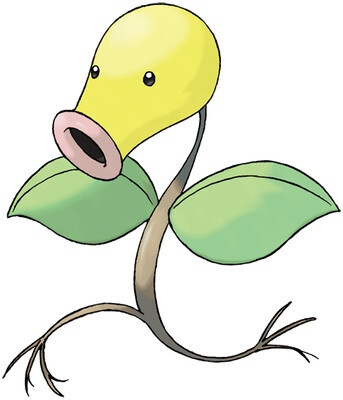
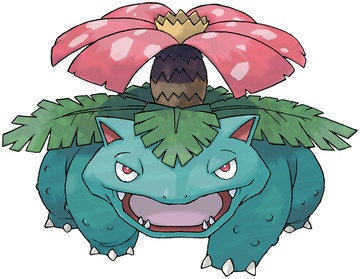
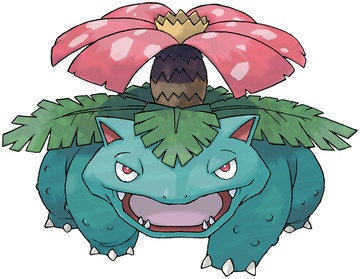
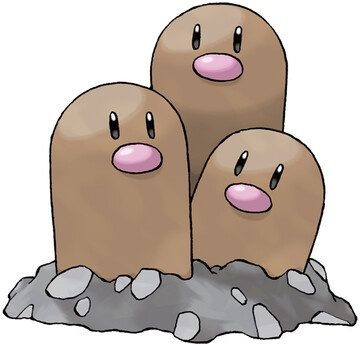
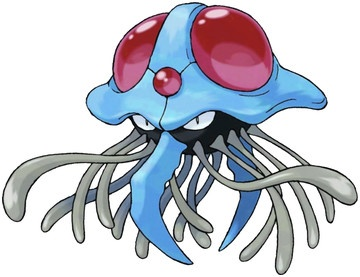
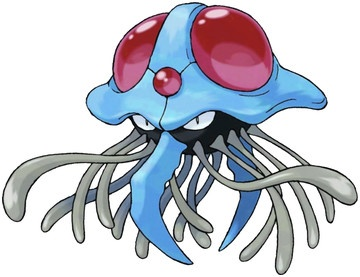
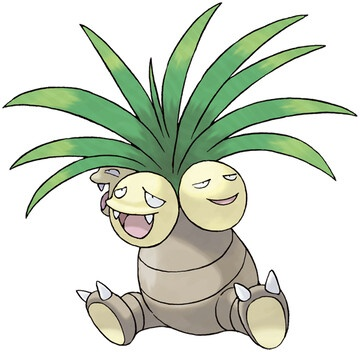
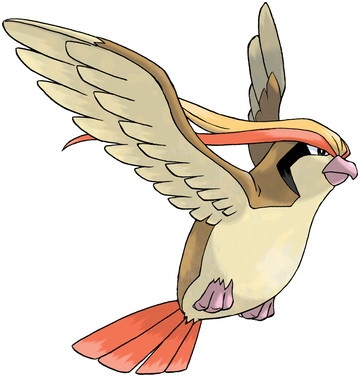
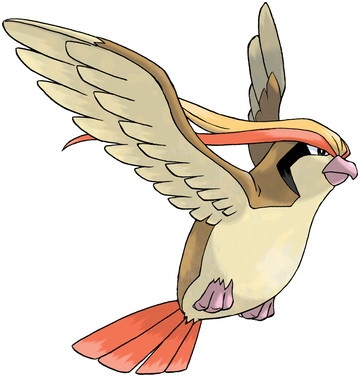
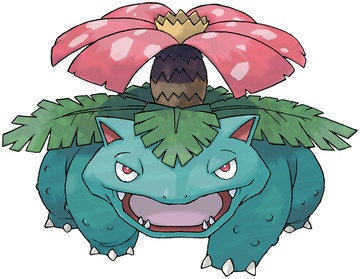
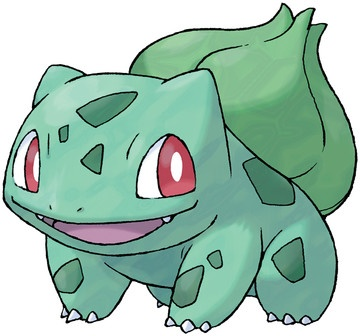
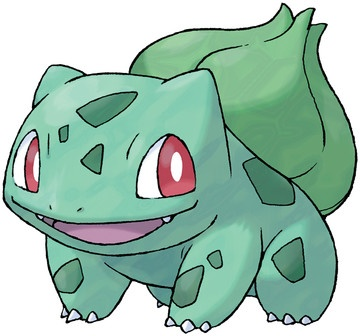
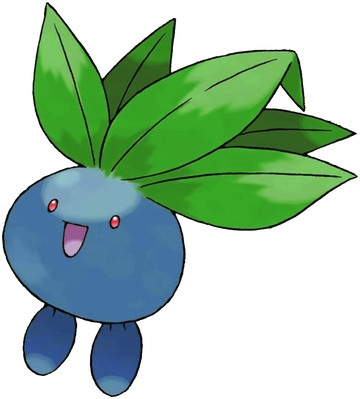
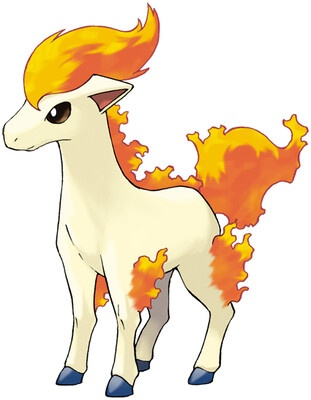
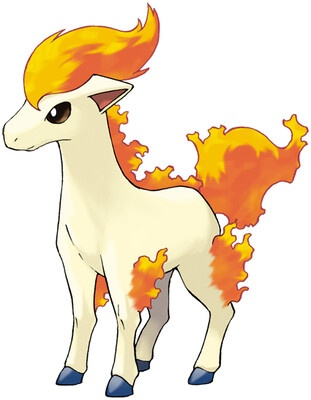

In [34]:
user_query = "root pokemon"
image_mode_result = search_pokemon(user_query, mode="image")
text_mode_result = search_pokemon(user_query, mode="text")
fusion_mode_result = search_pokemon(user_query, mode="fusion")
display_comparison_with_query(user_query, image_mode_result, text_mode_result, fusion_mode_result)